<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Testing-of-Code" data-toc-modified-id="Testing-of-Code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Testing of Code</a></span></li><li><span><a href="#Fit-the-Particle-Filter" data-toc-modified-id="Fit-the-Particle-Filter-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit the Particle Filter</a></span><ul class="toc-item"><li><span><a href="#Parallelize-All-Participants" data-toc-modified-id="Parallelize-All-Participants-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Parallelize All Participants</a></span></li><li><span><a href="#Test-Individual-Participants" data-toc-modified-id="Test-Individual-Participants-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Test Individual Participants</a></span></li></ul></li></ul></div>

# Testing of Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import distributions as dist
from collections import Counter
from scipy.optimize import minimize, Bounds
import math

In [2]:
from functools import partial, reduce
from multiprocessing import Pool

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from models import particle as ptcl

In [5]:
run = 0
stims, labels = ptcl.get_zmstims(400)
types = "cc"
Cparam = 0.65
mu0 = np.mean(stims, 0)
sigma0 = np.var(stims, 0)
lambda0 = np.ones(len(stims[0]))
a0 = np.ones(len(stims[0]))
n_labels = 4
feedback = [1, 2, 3, 1, 2, 2, 2, 4, 3, 1]

args = [Cparam, mu0, sigma0, lambda0, a0, types, n_labels, feedback]

model = ptcl.RationalParticle(args, decision = "MAP")

In [6]:
model.N = 1
model.partition = [0]

In [7]:
model.labelprob()

array([0.25, 0.25, 0.25, 0.25])

In [8]:
model.N = 2
model.partition = [0, 0]

In [9]:
model.labelprob()

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

# Fit the Particle Filter

Model Selection Logic:
1. run training trials with the model; feedback is provided, therefore, the label counts are updated according to the true category label during training
2. replicate 1. with several values for c and return all models
3. make predictions on hold out transfer data for all combinations
4. select best fitting c parameter for every participant

nb. fit only c parameter, keep others fixed

In [260]:
tbl_train = pd.read_csv("data/tbl_train.csv")
tbl_transfer = pd.read_csv("data/tbl_transfer.csv")

In [261]:
tbl_train["trial_id"] = tbl_train.groupby("participant").cumcount()+1

In [396]:
tbl_train.value_counts("participant")

participant
147    992
108    992
129    992
113    992
124    992
104    992
106    991
107    991
105    991
109    991
130    991
136    991
143    991
134    991
138    991
117    991
142    990
131    990
135    990
150    990
119    990
149    990
121    989
123    989
115    989
127    989
128    989
146    989
133    989
122    988
118    988
111    988
144    987
126    987
132    987
110    987
125    986
141    986
120    984
139    982
112    944
103    843
101    830
116    799
145    798
148    798
114    752
102    603
140    367
137    271
dtype: int64

In [268]:
tbl_train_small = tbl_train[tbl_train["trial_id"] < 40].copy()

In [273]:
tbl_train_small[tbl_train_small["participant"] == 104]["category_int"].unique()

array([3, 1, 2], dtype=int64)

## Parallelize All Participants

In [330]:
l_results_train = ptcl.multiprocessing_grid_search_particle(tbl_train_small)

100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.07it/s]


In [374]:
for l in l_results_train:
    l["tbl_transfer"] = tbl_transfer[tbl_transfer["participant"] == l["id"]].head(40)

37 seconds with 20 data points

143 seconds with 40 data points

In [375]:
l_results_transfer = ptcl.multiprocessing_prediction(l_results)

100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.04it/s]


In [376]:
df_results_transfer = reduce(lambda x, y: pd.concat([x, y]), l_results_transfer)

In [378]:
df_results_transfer["rank"] = df_results_transfer.groupby("id")["ll"].rank(ascending=False)

In [389]:
df_results_transfer.sort_values("rank").head(4)

,id,c,ll,rank
0,103.0,0.375,-29.041927,1.0
0,104.0,0.475,-32.535299,1.0
0,101.0,0.425,-31.319083,1.0
0,102.0,0.425,-40.441596,1.0


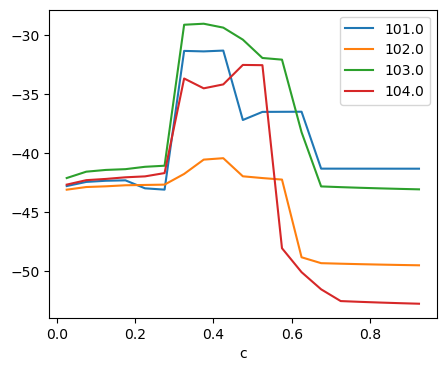

In [392]:
fig, ax = plt.subplots(figsize=(5, 4))
for label, df in df_results_transfer.groupby("id"):
    df.plot("c", "ll", ax=ax, label=label)
_ = plt.legend()

In [399]:
df_results_transfer.query("rank == 1")

,id,c,ll,rank
0,101.0,0.425,-31.319083,1.0
0,102.0,0.425,-40.441596,1.0
0,103.0,0.375,-29.041927,1.0
0,104.0,0.475,-32.535299,1.0


In [400]:
df_results_transfer.to_csv("data/tbl_results_transfer.csv")

## Test Individual Participants

In [275]:
stim_train_101 = tbl_train_small[tbl_train_small["participant"] == 101][["d1i", "d2i"]].to_numpy()
fb_train_101 = tbl_train_small[tbl_train_small["participant"] == 101]["category_int"].to_numpy()

In [276]:
ll, n_clusters, model = ptcl.fit_ll(
    np.array([.1]), stim_train_101, fb_train_101
)

In [282]:
stim_pred = tbl_transfer[tbl_transfer["participant"] == 101][["d1i", "d2i"]].to_numpy()[0:20,]

In [283]:
fb_pred = tbl_transfer[tbl_transfer["participant"] == 101]["category_int"].to_numpy()[0:20,]

In [293]:
d_pred = {"model": model, "stimuli": stim_pred, "feedback": fb_pred}

In [284]:
ll, K, model = ptcl.predict_ll(d_pred)

In [289]:
ll, K, model = ptcl.predict_ll(model, np.array([[-1000, -1000]]), np.array([[1]]))

In [ ]:
stimnum = l_results[3]["model"][10].register_item(stim, checkduplicate=False)
# compute posterior over observed features
l_results[3]["model"][10].computeposterior(stimnum)

In [ ]:
stimnum = l_results[5]["model"][10].register_item(stim, checkduplicate=False)
# compute posterior over observed features
l_results[5]["model"][10].computeposterior(stimnum)

In [ ]:
stimnum

In [ ]:
l_results[0]["model"].currentposterior

In [ ]:
l_results[0]["model"].stims

In [ ]:
l_results[0]["model"].additem_particle([3, 2])

In [ ]:
math.log(l_results[0]["model"].plf[-1].flatten("C")[2])

In [ ]:
p1 = tbl_train[tbl_train["participant"] == 101]

In [ ]:
p1 = p1.iloc[0:100,:].copy()


In [ ]:
ptcl.grid_search_particle(p1)

In [ ]:
l_results = list(map(ptcl.grid_search_particle, list_to_process_no_names))

In [ ]:
l_results

In [ ]:
l_results = ptcl.multiprocessing_grid_search_particle(tbl_train)

optimize particle filter
- takes too long, though

start_params = np.array([.5])

bounds = Bounds([0], [1])

def wrap_fit_particle(id, tbl_data):
    stimuli_subset = tbl_data[tbl_data["participant"] == id][["d1i", "d2i"]].to_numpy()
    feedback_subset = tbl_data[tbl_data["participant"] == id]["category"].to_numpy()
    c_seq = np.seq(0.025, 0.975, by=.05)
    lls = list()
    for c in c_seq:
        lls.append(fit_ll(c, stimuli_subset, feedback_subset))
    return lls

def wrap_optim(id, tbl_data):
    stimuli_subset = tbl_data[tbl_data["participant"] == id][["d1i", "d2i"]]
    feedback_subset = tbl_data[tbl_data["participant"] == id]["category"]
    res = minimize(
        ptcl.fit_ll, start_params, 
        args = (stimuli_subset, feedback_subset), 
        method = "trust-constr", bounds=bounds,
        options={'gtol': 1e-6, 'disp': True}
    )
    l_out = [id, res]
    return l_out

wrap_fit_partial = partial(ptcl.grid_search_particle, tbl_data = tbl_train)

f_partial = partial(wrap_optim, stimuli=tbl_train, feedback=feedback)
p = multiprocessing.Pool(2)
list_result = []
for x in p.imap(f_partial, participants):
    list_result.append(x)

res = minimize(
    ptcl.fit_ll, start_params, 
    args = (stimuli_np, feedback_np), 
    method = "trust-constr", bounds=bounds,
    options={'gtol': 1e-6, 'disp': True}
)